## Step 0: Why EDA?

Not all data comes in a neat little package ready to be modelled by the latest and greatest machine learning models.

Most of the time, you'll get a dataset you don't know much about. So before you can make any solid predictions, you'll to find out more.

This is where EDA comes in.

The main thing to remember is the first word. Exploratory. You're trying to figure out more about the data so you can build a model the best way you can.

You'll usually do this when you first look at a dataset but it'll continually happen as you learn more. EDA is an iterative process. There's no one way to do it either. It'll vary with each new dataset but there are some things you'll find yourself doing more often, we'll talk about those in this notebook.

## Step 1: Download the data

You can download the data for this notebook here: https://www.kaggle.com/c/titanic/data

## Step 2: Work through the notebook

First we will import all the relevant dependencies we need.

In [685]:
# Python imports
import math, time, random, datetime

# Data manipulation
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import missingno
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv

In [686]:
# Import training and testing data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
gender_submission = pd.read_csv('gender_submission.csv') # This is an example of what a submission should look like

In [687]:
# View the training data
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S


In [688]:
# View the test data (same columns as the training data)
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [689]:
# View the example submission dataframe
gender_submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


## Data Descriptions
**Survival:** 0 = No, 1 = Yes

**pclass (Ticket class):** 1 = 1st, 2 = 2nd, 3 = 3rd

**sex:** Sex

**Age:** Age in years

**sibsp:** number of siblings/spouses aboard the Titanic

**parch:** number of parents/children aboard the Titanic

**ticket:** Ticket number

**fare:** Passenger fare

**cabin:** Cabin number

**embarked:** Port of Embarkation, C = Cherbourg, Q = Queenstown, S = Southampton

In [690]:
train.describe()

,PassengerId,Survived,Pclass,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,8.000000,6.000000,512.329200


## What missing values are there?
What are the holes in our data?

These are rows which are missing a value or have NaN instead of something like the rest of the column.

<AxesSubplot:>

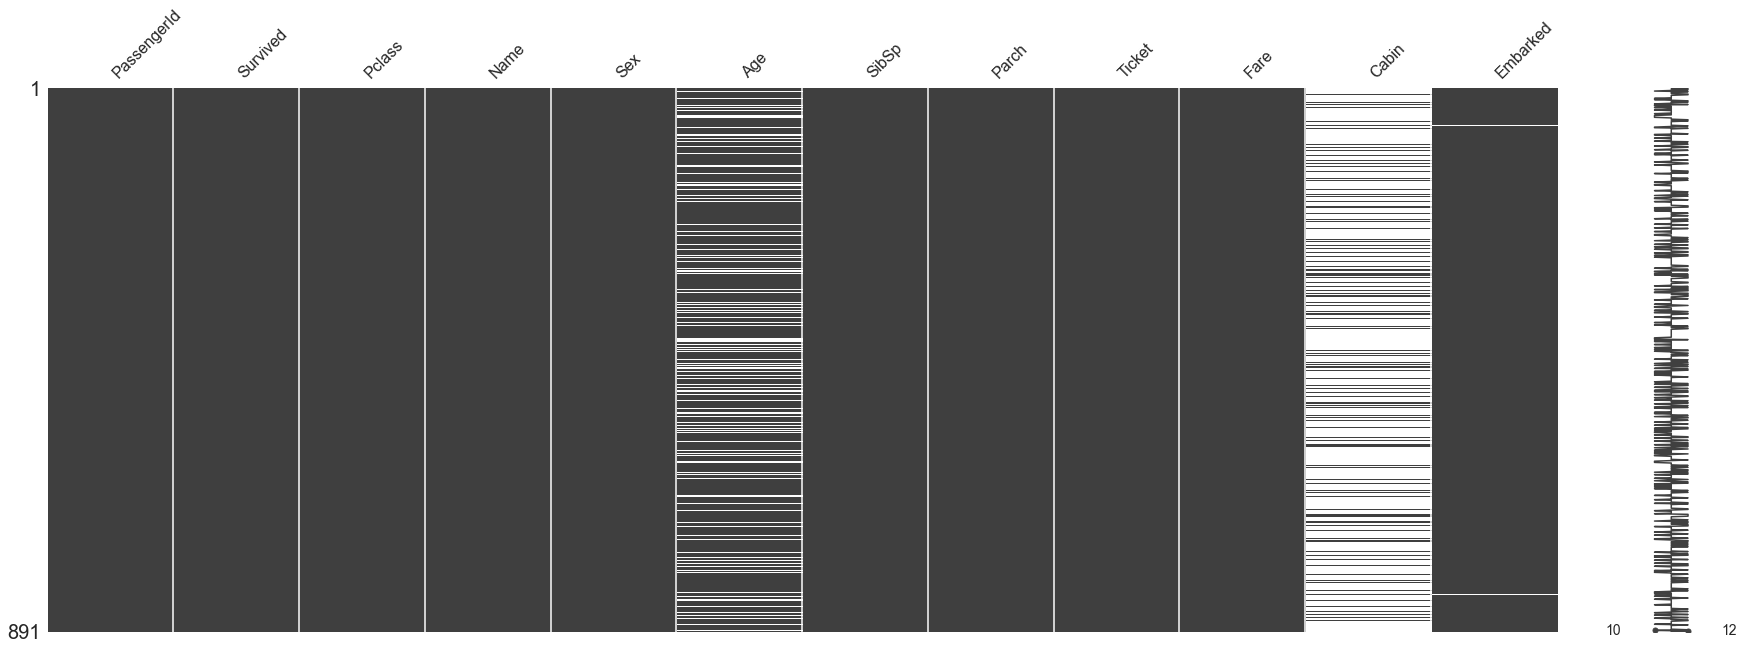

In [691]:
# Plot graphic or missing values
# figsize is jsut used to choose the size of the displayed figure (30x10 pixels in our case)
missingno.matrix(train, figsize=(30,10))

We can clearly see some missing values here. Especially in the cabin column.

It's important to visualise missing values early so we know where the major holes are in your dataset.

Knowing this information will help with your EDA and figuring out what kind of data cleaning and preprocessing is needed.

In [692]:
def find_missing_values(df, columns):
    """
    Find number of rows where certain columns are missing values.
    :param df: Target dataframe.
    :param columns: List of columns.
    :return: A dictionary of the number of rows missing for each column.
    """
    missing_vals = {}
    print("Number of missing values or NaN values for each column:")
    df_length = len(df)

    for column in columns:
        total_column_values = df[column].value_counts().sum()
        missing_vals[column] = df_length - total_column_values
    return missing_vals
missing_values = find_missing_values(train, columns=train.columns)
missing_values

Number of missing values or NaN values for each column:


{'PassengerId': 0,
 'Survived': 0,
 'Pclass': 0,
 'Name': 0,
 'Sex': 0,
 'Age': 177,
 'SibSp': 0,
 'Parch': 0,
 'Ticket': 0,
 'Fare': 0,
 'Cabin': 687,
 'Embarked': 2}

## To perform our data analysis, let's create two new dataframes
We'll create one for exploring discretised continuous variables (continuous variables which have been sorted into some kind of category) and another for exploring continuous variables.

In [693]:
df_bin = pd.DataFrame() # for discretised continuous variables (categorical variables)
df_con = pd.DataFrame() # for continuous variables

## What types are in the dataframe?
As a general rule of thumb, features with a datatype of object could be considered categorical features. And those which are floats or ints (numbers) could be considered numerical features.

However, as we dig deeper, we might find features which are numerical may actually be categorical.

The goal for the next few steps is to figure out how best to process the data so our machine learning model can learn from it.

Ideally, all the features will be encoded into a numerical value of some kind.

In [694]:
# Different data types im the dataset
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age             object
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

## Let's explore each of these features individually
We'll go through each column iteratively and see which ones to use in our first models. Some may need more preprocessing than others to get ready.

In [695]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S


### Target Feature: Survived
Description: Whether the passenger survived or not.

Key: 0 = did not survive, 1 = survived

This is the variable we want our machine learning model to predict based off all the others.

0    549
1    342
Name: Survived, dtype: int64


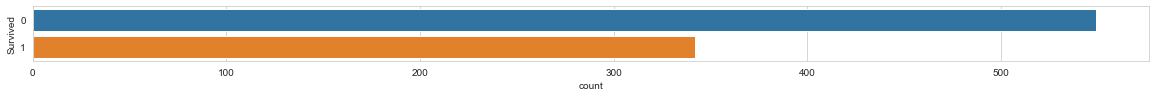

In [696]:
# How many people survived?
fig = plt.figure(figsize=(20,1))
sns.countplot(y='Survived', data=train)
print(train.Survived.value_counts())

In [697]:
# Let's add this to our subset dataframes
df_bin['Survived'] = train['Survived']
df_con['Survived'] = train['Survived']

In [698]:
df_bin.head()

,Survived
0,0
1,1
2,1
3,1
4,0


In [699]:
df_con.head()

,Survived
0,0
1,1
2,1
3,1
4,0


### Feature: PClass
Description: The ticket class of the passenger.

Key: 1 = 1st, 2 = 2nd, 3 = 3rd

#### Let's plot the distribution

We will look at the distribution of each feature first if we can to understand what kind of spread there is across the dataset.

For example, if there are values which are completely outside of the distribution, we may not want to include them in our model.

/Users/alexandrewavrant/opt/anaconda3/envs/kaggle/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Pclass', ylabel='Density'>

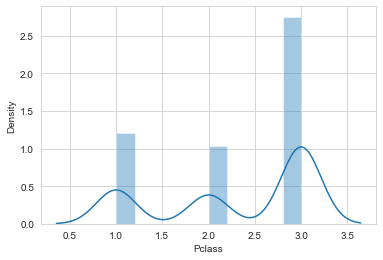

In [700]:
sns.distplot(train.Pclass)

We can see with this feature, the values are numerical (1, 2 and 3) but they are categories.

How do we know this? Because a passenger in Class 3 doesn't necessarily equal a passenger in Class 2 + a passenger in Class 1.

In [701]:
# How many missing variables does Pclass have?
missing_values['Pclass']

0

Since there are no missing values in Pclass, let's add it to our sub dataframes.

In [702]:
df_bin['Pclass'] = train['Pclass']
df_con['Pclass'] = train['Pclass']

In [703]:
df_con.head()

,Survived,Pclass
0,0,3
1,1,1
2,1,3
3,1,1
4,0,3


### Feature: Name
Description: The name of the passenger.

In [704]:
# How many different names are there?
train.Name.value_counts()

Braund, Mr. Owen Harris                     1
Boulos, Mr. Hanna                           1
Frolicher-Stehli, Mr. Maxmillian            1
Gilinski, Mr. Eliezer                       1
Murdlin, Mr. Joseph                         1
                                           ..
Kelly, Miss. Anna Katherine "Annie Kate"    1
McCoy, Mr. Bernard                          1
Johnson, Mr. William Cahoone Jr             1
Keane, Miss. Nora A                         1
Dooley, Mr. Patrick                         1
Name: Name, Length: 891, dtype: int64

In [705]:
len(train)

891

Every row has a unique name. This is equivalent to the passenger ID. But name could be used differently.

Can you think of ways you could reduce the number of different names? Or create new features out of the names?

Note: Because of so many different names and to keep this EDA fast, we won't move forward using the name variable.

### Feature: Sex
Description: The sex of the passenger (male or female).

<AxesSubplot:xlabel='count', ylabel='Sex'>

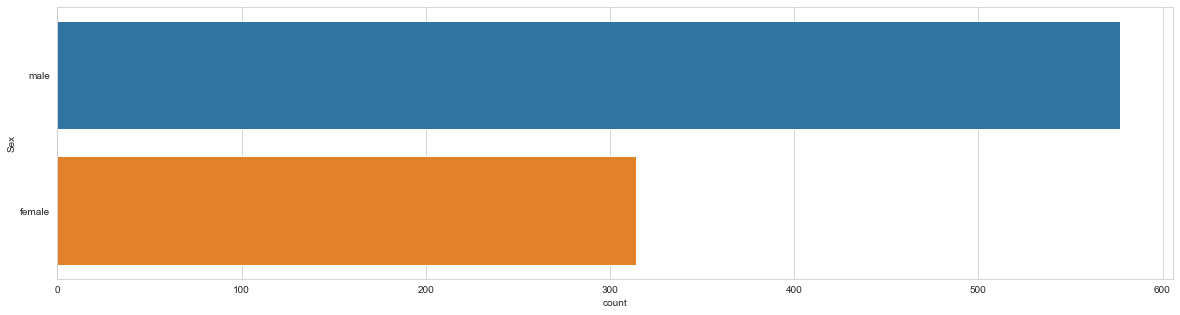

In [706]:
# Let's view the distribution of the sex
fig = plt.figure(figsize=(20,5))
sns.countplot(y='Sex', data=train)

In [707]:
# Are there any missing values in the Sex column?
missing_values['Sex']
# train.Sex.isnull().sum()

0

Since this is already binary variable (male or female), let's add it straight to our subset dataframes.

In [708]:
train.Sex.head()

0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: object

In [709]:
# Add Sex to the subset dataframes
df_bin['Sex'] = train['Sex']
df_bin['Sex'] = np.where(df_bin['Sex'] == 'female', 1, 0)

df_con['Sex'] = train['Sex']

/Users/alexandrewavrant/opt/anaconda3/envs/kaggle/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/alexandrewavrant/opt/anaconda3/envs/kaggle/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


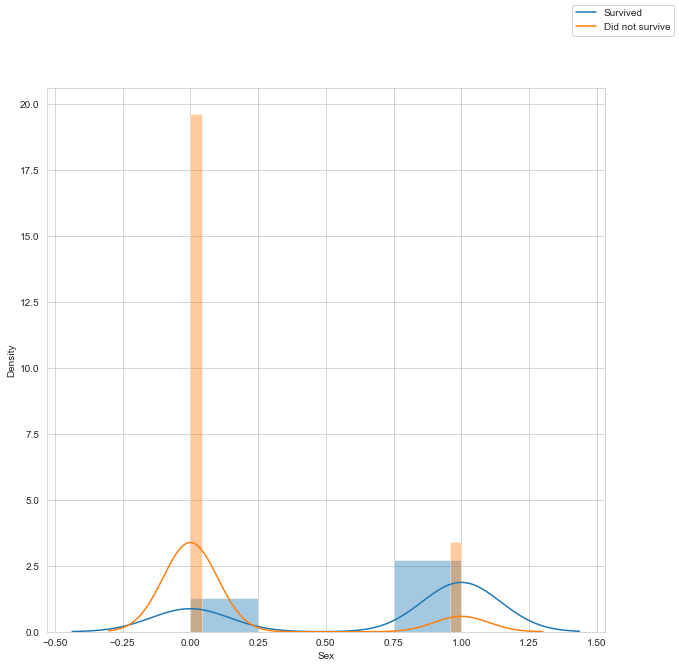

In [710]:
# How does the Sex variable look compared to Survival?
# We can see this because they're both binaries.
fig = plt.figure(figsize=(10, 10))
sns.distplot(df_bin.loc[df_bin['Survived'] == 1]['Sex'], kde_kws={'label': 'Survived'});
sns.distplot(df_bin.loc[df_bin['Survived'] == 0]['Sex'], kde_kws={'label': 'Did not survive'});
fig.legend();

Not many people survived. But of those who did, more were female.

### Feature: Age

Description: The age of the passenger.

In [711]:
# How many missing values does age have?
missing_values['Age']

177

Out of a total 891 rows, that's almost one quarter of the dataset.

What would you do with these missing values?

Could replace them with the average age? What's the pro's and con's of doing this?

Or would you get rid of them completely?

We won't answer these questions in our initial EDA but this is something we would definitely revisit at a later date.

In [712]:
# Once the Age values have been fixed up, we can add them to our sub dataframes.
# df_bin['Age'] = pd.cut(train['Age'], 10) # bucketed/binned into different categories
# df_con['Age'] = train['Age'] # non-bucketed

**Challenge:** How would you fill the missing variables in the Age column?

#### Function to create count and distribution visualisations

In [713]:
def plot_count_dist(data, bin_df, label_column, target_column, figsize=(20, 5), use_bin_df=False):
    """
    Function to plot counts and distributions of a label variable and
    target variable side by side.
    :param data: target dataframe
    :param bin_df: binned dataframe for countplot
    :param label_column: binary labelled column
    :param target_column: column you want to view counts and distributions
    :param figsize: size of figure (width, height)
    :param use_bin_df: whether or not to use the bin_df, default False
    """
    if use_bin_df:
        fig = plt.figure(figsize=figsize)
        plt.subplot(1, 2, 1)
        sns.countplot(y=target_column, data=bin_df);
        plt.subplot(1, 2, 2)
        sns.distplot(data.loc[data[label_column] == 1][target_column],
                     kde_kws={"label": "Survived"});
        sns.distplot(data.loc[data[label_column] == 0][target_column],
                     kde_kws={"label": "Did not survive"});
        fig.legend()
    else:
        fig = plt.figure(figsize=figsize)
        plt.subplot(1, 2, 1)
        sns.countplot(y=target_column, data=data);
        plt.subplot(1, 2, 2)
        sns.distplot(data.loc[data[label_column] == 1][target_column],
                     kde_kws={"label": "Survived"});
        sns.distplot(data.loc[data[label_column] == 0][target_column],
                     kde_kws={"label": "Did not survive"});
        fig.legend()

### Feature: SibSp
Description: The number of siblings/spouses the passenger has aboard the Titanic.

In [714]:
# How many missing values does SibSp have?
missing_values['SibSp']

0

In [715]:
# What values are there?
train.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

Let's add SibSp to our subset dataframes and view the distributions.

In [716]:
# Add SibSp to subset dataframes
df_bin['SibSp'] = train['SibSp']
df_con['SibSp'] = train['SibSp']

/Users/alexandrewavrant/opt/anaconda3/envs/kaggle/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/alexandrewavrant/opt/anaconda3/envs/kaggle/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


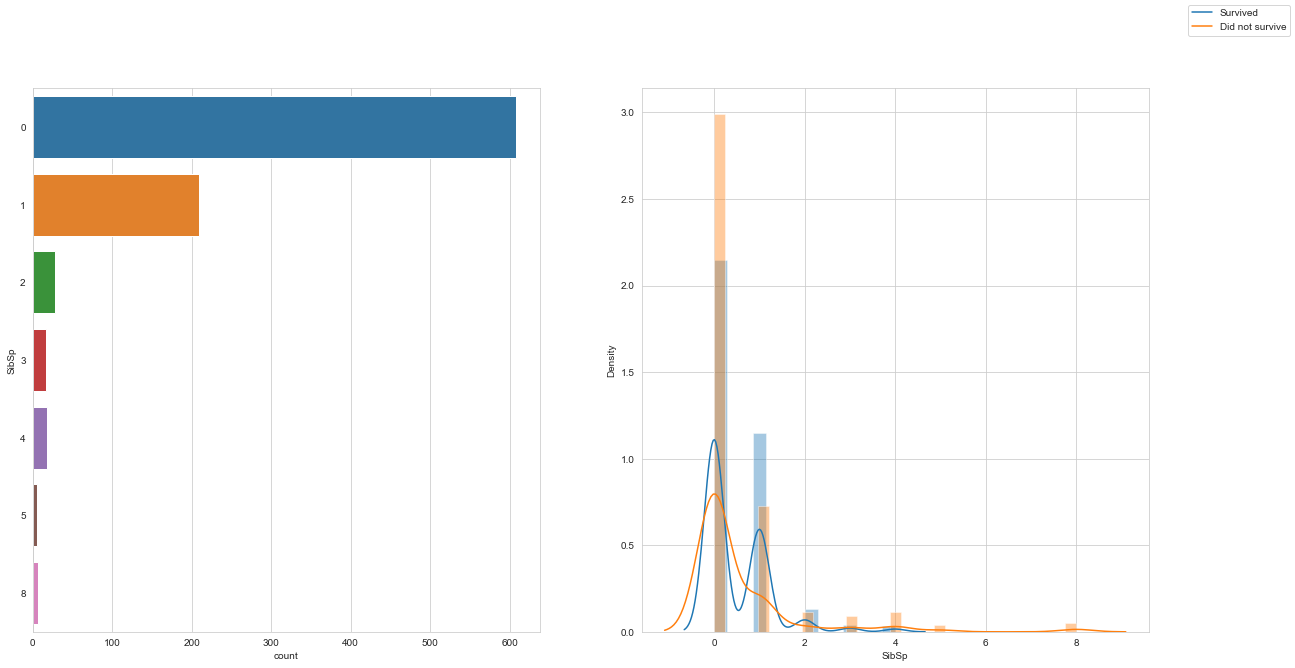

In [717]:
# Visualise the counts of SibSp and the distribution of the values
# against Survived
plot_count_dist(data=train,
                bin_df=df_bin,
                label_column='Survived',
                target_column='SibSp',
                figsize=(20, 10),
                use_bin_df=False)

What does the graph on the right tell us?

### Feature: Parch

Description: The number of parents/children the passenger has aboard the Titanic.

Since this feature is similar to SibSp, we'll do a similar analysis.

In [718]:
# How many missing values does SibSp have?
missing_values['SibSp']

0

In [719]:
train.Parch.value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [720]:
# Add Parch to subset dataframes
df_bin['Parch'] = train['Parch']
df_con['Parch'] = train['Parch']

/Users/alexandrewavrant/opt/anaconda3/envs/kaggle/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/alexandrewavrant/opt/anaconda3/envs/kaggle/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


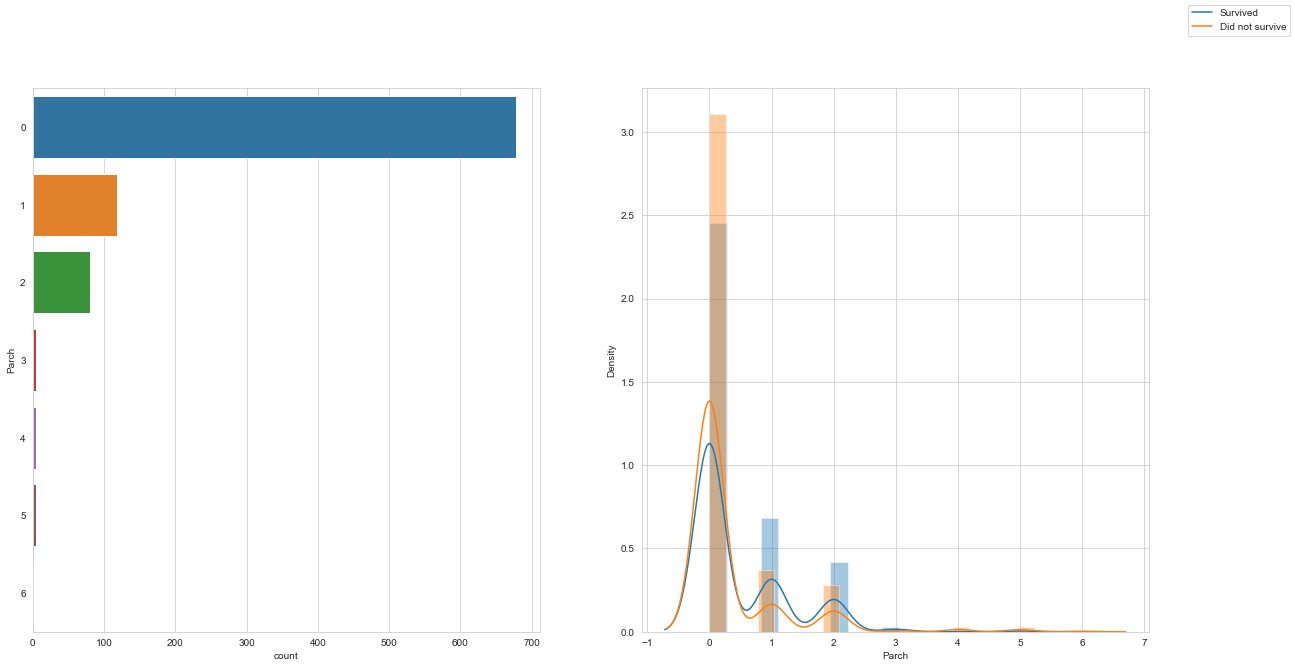

In [721]:
# Visualise the counts of SibSp and the distribution of the values
# against Survived
plot_count_dist(data=train,
                bin_df=df_bin,
                label_column='Survived',
                target_column='Parch',
                figsize=(20, 10),
                use_bin_df=False)

**What does the graph on the right tell us about Parch?**
If you have 1 or 2 parents of children, your chance of survive are higher than if you have none.

In [722]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S


In [723]:
df_con.head()

,Survived,Pclass,Sex,SibSp,Parch
0,0,3,male,1,0
1,1,1,female,1,0
2,1,3,female,0,0
3,1,1,female,1,0
4,0,3,male,0,0


### Feature: Ticket
Description: The ticket number of the boarding passenger.

In [724]:
missing_values['Ticket']

0

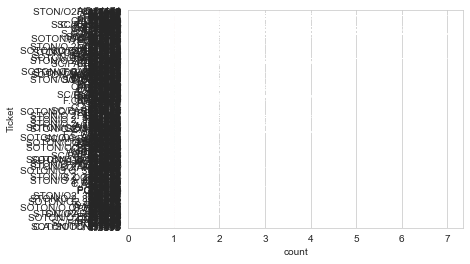

In [725]:
# How many kinds of tickets are there?
sns.countplot(y="Ticket", data=train);

That doesn't look too good, what about another way of looking at it?

In [726]:
# How many kinds of tickets are there?
train.Ticket.value_counts()[:20]

347082          7
CA. 2343        7
1601            7
3101295         6
CA 2144         6
347088          6
S.O.C. 14879    5
382652          5
LINE            4
PC 17757        4
17421           4
349909          4
113760          4
4133            4
113781          4
W./C. 6608      4
2666            4
19950           4
347077          4
C.A. 31921      3
Name: Ticket, dtype: int64

In [727]:
# How many unique kinds of Ticket are there?
print(f"There are {len(train.Ticket.unique())} unique Ticket values.")

There are 681 unique Ticket values.


681 unique values is too many for now. So we won't use Ticket in our subset dataframes.

There may be some way to reduce this down.

**Challenge:** How could you reduce the Ticket feature? Is it even possible?

Hint: It may be similar to what you could do with Name.

### Feature: Fare

Description: How much the ticket cost.

In [728]:
# How many missing values does Fare have?
missing_values['Fare']

0

<AxesSubplot:xlabel='count', ylabel='Fare'>

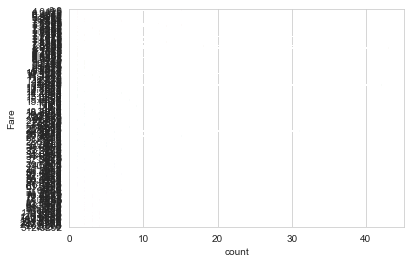

In [729]:
sns.countplot(y='Fare', data=train)

In [730]:
train.Fare.head()

0     7.2500
1    71.2833
2     7.9250
3    53.1000
4     8.0500
Name: Fare, dtype: float64

In [731]:
# What kind of variable is Fare?
train.Fare.dtype

dtype('float64')

In [732]:
# How many unique kinds of Fare are there?
print(f"There are {len(train.Fare.unique())} unique Fare values.")

There are 248 unique Fare values.


Because Fare is a float (number) let's add it as it is to our continuous sub dataframe but to add it to our categorical sub dataframe, we'll cut it into bins.

In [733]:
df_con['Fare'] = train['Fare']
df_bin['Fare'] = pd.cut(x=train['Fare'], bins=5) # discretised

In [734]:
df_bin.Fare.value_counts()

(-0.512, 102.466]     838
(102.466, 204.932]     33
(204.932, 307.398]     17
(409.863, 512.329]      3
(307.398, 409.863]      0
Name: Fare, dtype: int64

In [735]:
df_con.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare
0,0,3,male,1,0,7.2500
1,1,1,female,1,0,71.2833
2,1,3,female,0,0,7.9250
3,1,1,female,1,0,53.1000
4,0,3,male,0,0,8.0500


/Users/alexandrewavrant/opt/anaconda3/envs/kaggle/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/alexandrewavrant/opt/anaconda3/envs/kaggle/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


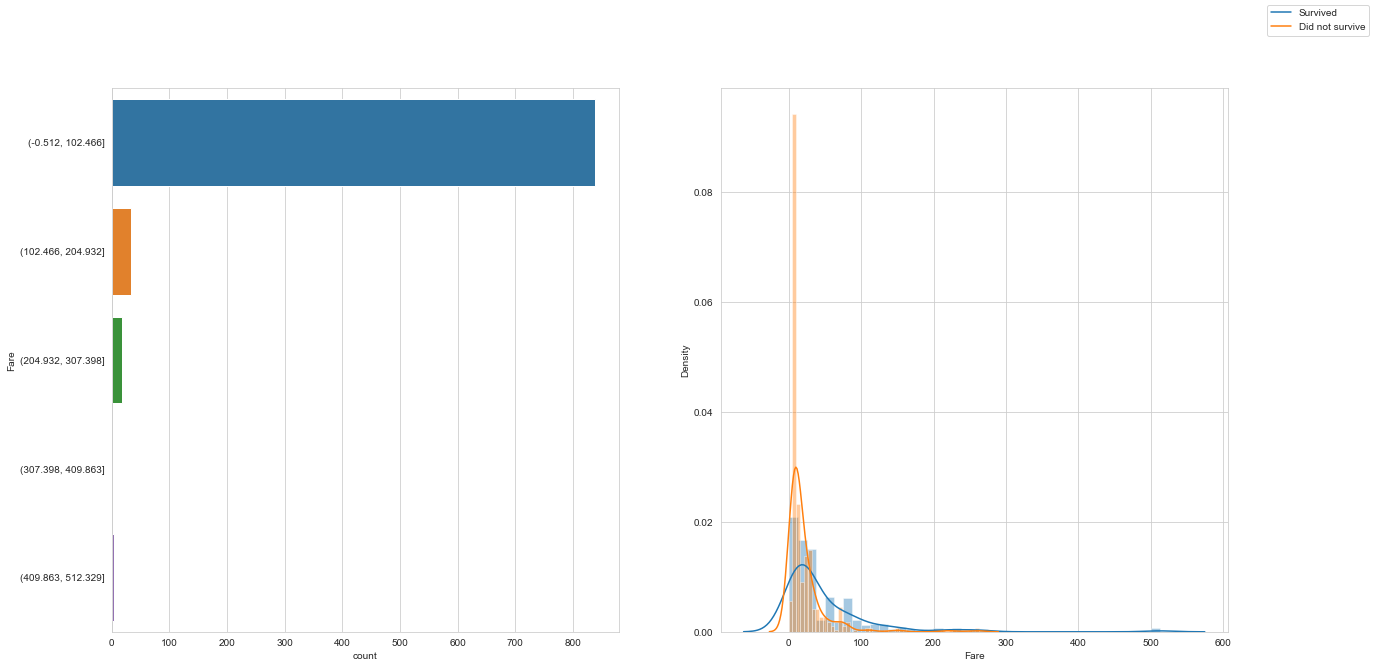

In [736]:
# Visualise the Fare bin counts as well as the Fare distribution versus Survived.
plot_count_dist(data=train,
                bin_df=df_bin,
                label_column='Survived',
                target_column='Fare',
                figsize=(20,10),
                use_bin_df=True)

**Challenge:** How would you change the Fare bins?

### Feature: Cabin
Description: The cabin number where the passenger was staying.

In [737]:
# How many missing values does Cabin have?
missing_values['Cabin']

687

In [738]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S


In [739]:
# What do the Cabin values look like?
train.Cabin.value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64

Since there are too many missing values, we won't use Cabin for our initial models and won't add it to our sub dataframes.

But how could you modify cabin to be more usable?

What could you do about the missing values?

### Feature: Embarked

Description: The port where the passenger boarded the Titanic.

Key: C = Cherbourg, Q = Queenstown, S = Southampton

In [740]:
# How many missing values does Embarked have?
missing_values['Embarked']

2

In [741]:
# What kind of values are in Embarked?
train.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

Embarked is a categorical variable because there are 3 categories which a passenger could have boarded on.

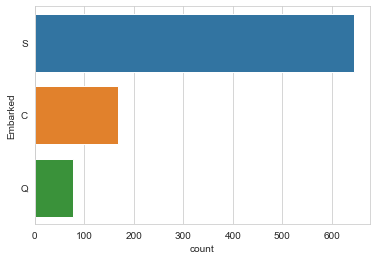

In [742]:
# What do the counts look like?
sns.countplot(y='Embarked', data=train);

**How can we deal with the 2 missing values of Embarked?**

One option is to drop the two rows which don't have an Embarked value.

Another option would be to randomly assign a value of C, Q or S to each row.

What are the pros and cons of each?

For now, we will remove those rows.

In [743]:
# Add Embarked to sub dataframes
df_bin['Embarked'] = train['Embarked']
df_con['Embarked'] = train['Embarked']

In [744]:
# Remove Embarked rows which are missing values
print(len(df_con))
df_con = df_con.dropna(subset=['Embarked'])
df_bin = df_bin.dropna(subset=['Embarked'])
print(len(df_con))

891
889


We've removed the two rows with missing values for Embarked, now we can add Embarked to our sub dataframes.

In [745]:
df_bin.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,3,0,1,0,"(-0.512, 102.466]",S
1,1,1,1,1,0,"(-0.512, 102.466]",C
2,1,3,1,0,0,"(-0.512, 102.466]",S
3,1,1,1,1,0,"(-0.512, 102.466]",S
4,0,3,0,0,0,"(-0.512, 102.466]",S


In [746]:
df_con.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,3,male,1,0,7.2500,S
1,1,1,female,1,0,71.2833,C
2,1,3,female,0,0,7.9250,S
3,1,1,female,1,0,53.1000,S
4,0,3,male,0,0,8.0500,S


## Feature Encoding
Now we have our two sub dataframes ready. We can encode the features so they're ready to be used with our machine learning models.

We will encode our binned dataframe (df_bin) with one-hot encoding and our continuous dataframe (df_con) with the label encoding function from sklearn.

**What does "one-hot encode" mean?**
Creating an new dataframe that is going to give things a 0 to what it isn't and a 1 to what is.

In [747]:
# One-hot encode binned variables
one_hot_cols = df_bin.columns.tolist()
one_hot_cols.remove('Survived')
df_bin_enc = pd.get_dummies(df_bin, columns=one_hot_cols)

df_bin_enc.head()

,Survived,Pclass_1,Pclass_2,Pclass_3,Sex_0,Sex_1,SibSp_0,SibSp_1,SibSp_2,SibSp_3,...,Parch_5,Parch_6,"Fare_(-0.512, 102.466]","Fare_(102.466, 204.932]","Fare_(204.932, 307.398]","Fare_(307.398, 409.863]","Fare_(409.863, 512.329]",Embarked_C,Embarked_Q,Embarked_S
0,0,0,0,1,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
1,1,1,0,0,0,1,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
2,1,0,0,1,0,1,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,1,1,0,0,0,1,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
4,0,0,0,1,1,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [748]:
# One hot encode the categorical columns
df_embarked_one_hot = pd.get_dummies(df_con['Embarked'],
                                     prefix='embarked')

df_sex_one_hot = pd.get_dummies(df_con['Sex'],
                                prefix='sex')

df_plcass_one_hot = pd.get_dummies(df_con['Pclass'],
                                   prefix='pclass')

In [749]:
# Combine the one hot encoded columns with df_con_enc
df_con_enc = pd.concat([df_con,
                        df_embarked_one_hot,
                        df_sex_one_hot,
                        df_plcass_one_hot], axis=1)

# Drop the original categorical columns (because now they've been one hot encoded)
df_con_enc = df_con_enc.drop(['Pclass', 'Sex', 'Embarked'], axis=1)

In [750]:
# Let's look at df_con_enc
df_con_enc.head(20)

,Survived,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,1,0,71.2833,1,0,0,1,0,1,0,0
2,1,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,1,0,53.1000,0,0,1,1,0,1,0,0
4,0,0,0,8.0500,0,0,1,0,1,0,0,1
5,0,0,0,8.4583,0,1,0,0,1,0,0,1
6,0,0,0,51.8625,0,0,1,0,1,1,0,0
7,0,3,1,21.0750,0,0,1,0,1,0,0,1
8,1,0,2,11.1333,0,0,1,1,0,0,0,1
9,1,1,0,30.0708,1,0,0,1,0,0,1,0


## Start Building Machine Learning Models

Now our data has been manipulating and converted to numbers, we can run a series of different machine learning algorithms over it to find which yield the best results.

## Let's seperate the data

In [751]:
# Seclect the dataframe we want to use first for predictions
selected_df = df_con_enc

In [752]:
selected_df.head()

,Survived,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,1,0,71.2833,1,0,0,1,0,1,0,0
2,1,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,1,0,53.1000,0,0,1,1,0,1,0,0
4,0,0,0,8.0500,0,0,1,0,1,0,0,1


In [753]:
# Split the dataframe into data and labels
X_train = selected_df.drop(['Survived'], axis=1) # data
y_train = selected_df.Survived # labels

In [754]:
# Shape of the data
X_train.shape

(889, 11)

In [755]:
X_train.head()

,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,0,71.2833,1,0,0,1,0,1,0,0
2,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,0,53.1000,0,0,1,1,0,1,0,0
4,0,0,8.0500,0,0,1,0,1,0,0,1


In [756]:
# Shape of the labels
y_train.shape

(889,)

## Define a function to fit machine learning algorithms

Since many of the algorithms we will use are from the sklearn library, they all take similar (practically the same) inputs and produce similar outputs.

To prevent writing code multiple times, we will functionise fitting the model and returning the accuracy scores.

In [757]:
# Function that runs the requested algorithm and returns the accuracy metrics
def fit_ml_algo(algo, X_train, y_train, cv):

    # One Pass
    model = algo.fit(X_train, y_train)
    acc = round(model.score(X_train, y_train) * 100, 2)

    # Cross Validation
    train_pred = model_selection.cross_val_predict(algo,
                                                  X_train,
                                                  y_train,
                                                  cv=cv,
                                                  n_jobs = -1)

    # Cross-validation accuracy metric
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)

    return train_pred, acc, acc_cv

### Logistic Regression

In [758]:
# Logistic Regression
start_time = time.time()
train_pred_log, acc_log, acc_cv_log = fit_ml_algo(algo=LogisticRegression(),
                                                  X_train=X_train,
                                                  y_train=y_train,
                                                  cv=10)
log_time = (time.time() - start_time)
print("Accuracy: %s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

/Users/alexandrewavrant/opt/anaconda3/envs/kaggle/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/alexandrewavrant/opt/anaconda3/envs/kaggle/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

Accuracy: 79.98
Accuracy CV 10-Fold: 79.42
Running Time: 0:00:00.376839


/Users/alexandrewavrant/opt/anaconda3/envs/kaggle/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/alexandrewavrant/opt/anaconda3/envs/kaggle/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

### K-Nearest Neighbours

In [759]:
# k-Nearest Neighbours
start_time = time.time()
train_pred_knn, acc_knn, acc_cv_knn = fit_ml_algo(algo=KNeighborsClassifier(),
                                                  X_train=X_train,
                                                  y_train=y_train,
                                                  cv=10)
knn_time = (time.time() - start_time)
print(f"Accuracy: {acc_knn}")
print(f"Accuracy CV 10-Fold: {acc_cv_knn}")
print(f"Running Time: {datetime.timedelta(seconds=knn_time)}")

Accuracy: 83.69
Accuracy CV 10-Fold: 76.38
Running Time: 0:00:00.082204


### Gaussian Naive Bayes

In [760]:
# Gaussian Naive Bayes
start_time = time.time()
train_pred_gaussian, acc_gaussian, acc_cv_gaussian = fit_ml_algo(algo=GaussianNB(),
                                                  X_train=X_train,
                                                  y_train=y_train,
                                                  cv=10)
gaussian_time = (time.time() - start_time)
print(f"Accuracy: {acc_gaussian}")
print(f"Accuracy CV 10-Fold: {acc_cv_gaussian}")
print(f"Running Time: {datetime.timedelta(seconds=gaussian_time)}")

Accuracy: 78.52
Accuracy CV 10-Fold: 77.95
Running Time: 0:00:00.041664


### Linear Support Vector Machines (SVC)

In [761]:
# Linear SVC
start_time = time.time()
train_pred_linear_svc, acc_linear_svc, acc_cv_linear_svc = fit_ml_algo(algo=LinearSVC(),
                                                  X_train=X_train,
                                                  y_train=y_train,
                                                  cv=10)
linear_svc_time = (time.time() - start_time)
print(f"Accuracy: {acc_linear_svc}")
print(f"Accuracy CV 10-Fold: {acc_cv_linear_svc}")
print(f"Running Time: {datetime.timedelta(seconds=linear_svc_time)}")

/Users/alexandrewavrant/opt/anaconda3/envs/kaggle/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/alexandrewavrant/opt/anaconda3/envs/kaggle/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/alexandrewavrant/opt/anaconda3/envs/kaggle/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/alexandrewavrant/opt/anaconda3/envs/kaggle/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/alexandrewavrant/opt/anaconda3/envs/kaggle/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

Accuracy: 68.95
Accuracy CV 10-Fold: 77.95
Running Time: 0:00:00.780001


/Users/alexandrewavrant/opt/anaconda3/envs/kaggle/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/alexandrewavrant/opt/anaconda3/envs/kaggle/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### Stochastic Gradient Descent

In [762]:
# Stochastic Gradient Descent
start_time = time.time()
train_pred_sgd, acc_sgd, acc_cv_sgd = fit_ml_algo(SGDClassifier(),
                                                  X_train,
                                                  y_train,
                                                  10)
sgd_time = (time.time() - start_time)
print("Accuracy: %s" % acc_sgd)
print("Accuracy CV 10-Fold: %s" % acc_cv_sgd)
print("Running Time: %s" % datetime.timedelta(seconds=sgd_time))

Accuracy: 61.75
Accuracy CV 10-Fold: 72.55
Running Time: 0:00:00.457852


### Decision Tree Classifier

In [763]:
# Decision Tree Classifier
start_time = time.time()
train_pred_dt, acc_dt, acc_cv_dt = fit_ml_algo(DecisionTreeClassifier(),
                                               X_train,
                                               y_train,
                                               10)
dt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_dt)
print("Accuracy CV 10-Fold: %s" % acc_cv_dt)
print("Running Time: %s" % datetime.timedelta(seconds=dt_time))

Accuracy: 92.46
Accuracy CV 10-Fold: 79.98
Running Time: 0:00:00.476191


### Gradient Boost Trees

In [764]:
# Gradient Boosting Trees
start_time = time.time()
train_pred_gbt, acc_gbt, acc_cv_gbt = fit_ml_algo(GradientBoostingClassifier(),
                                                  X_train,
                                                  y_train,
                                                  10)
gbt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gbt)
print("Accuracy CV 10-Fold: %s" % acc_cv_gbt)
print("Running Time: %s" % datetime.timedelta(seconds=gbt_time))

Accuracy: 86.61
Accuracy CV 10-Fold: 80.65
Running Time: 0:00:00.209598


## CatBoost Algorithm
CatBoost is a state-of-the-art open-source gradient boosting on decision trees library.

It's simple and easy to use. And is now regularly one of my go-to algorithms for any kind of machine learning task.

In [765]:
# View the data for the CatBoost model
X_train.head()

,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,0,71.2833,1,0,0,1,0,1,0,0
2,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,0,53.1000,0,0,1,1,0,1,0,0
4,0,0,8.0500,0,0,1,0,1,0,0,1


In [766]:
# View the labels for the CatBoost model
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [767]:
# Define the categorical features for the CatBoost model
cat_features = np.where(X_train.dtypes != np.float)[0]
cat_features

/var/folders/yl/pr52dtxn48s9tqvcb70mkk340000gn/T/ipykernel_42166/4203748581.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cat_features = np.where(X_train.dtypes != np.float)[0]


array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10])

This means Catboost has picked up that all variables except Fare can be treated as categorical.

In [768]:
# Use the CatBoost Pool() function to pool together the training data and categorical feature labels
train_pool = Pool(X_train,
                  y_train,
                  cat_features)

In [769]:
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [773]:
# CatBoost model definition
catboost_model = CatBoostClassifier(iterations=1000,
                                    custom_loss=['Accuracy'],
                                    loss_function='Logloss')

# Fit CatBoost model
catboost_model.fit(train_pool,
                   plot=True)

# CatBoost accuracy
acc_catboost = round(catboost_model.score(X_train, y_train) * 100, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.009797
0:	learn: 0.6862830	total: 2.53ms	remaining: 2.52s
1:	learn: 0.6809444	total: 3.84ms	remaining: 1.91s
2:	learn: 0.6751692	total: 5.34ms	remaining: 1.77s
3:	learn: 0.6689060	total: 6.89ms	remaining: 1.72s
4:	learn: 0.6632144	total: 8.43ms	remaining: 1.68s
5:	learn: 0.6576488	total: 9.66ms	remaining: 1.6s
6:	learn: 0.6544441	total: 10.3ms	remaining: 1.46s
7:	learn: 0.6490635	total: 11.9ms	remaining: 1.48s
8:	learn: 0.6443241	total: 13.6ms	remaining: 1.5s
9:	learn: 0.6395935	total: 15.4ms	remaining: 1.53s
10:	learn: 0.6345186	total: 17.4ms	remaining: 1.56s
11:	learn: 0.6305316	total: 18.9ms	remaining: 1.56s
12:	learn: 0.6275610	total: 19.8ms	remaining: 1.5s
13:	learn: 0.6225020	total: 21.5ms	remaining: 1.51s
14:	learn: 0.6179503	total: 23.3ms	remaining: 1.53s
15:	learn: 0.6140480	total: 24.2ms	remaining: 1.49s
16:	learn: 0.6100034	total: 25.7ms	remaining: 1.49s
17:	learn: 0.6049646	total: 28.1ms	remaining: 1.53s
18:	learn: 0.6025760	total: 28.6ms	remaining: 1

In [774]:
# How long will this take?
start_time = time.time()

# Set params for cross-validation as same as initial model
cv_params = catboost_model.get_params()

# Run the cross-validation for 10-folds (same as the other models)
cv_data = cv(train_pool,
             cv_params,
             fold_count=10,
             plot=True)

# How long did it take?
catboost_time = (time.time() - start_time)

# CatBoost CV results save into a dataframe (cv_data), let's withdraw the maximum accuracy score
acc_cv_catboost = round(np.max(cv_data['test-Accuracy-mean']) * 100, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6746718	test: 0.6751020	best: 0.6751020 (0)
1:	learn: 0.6573540	test: 0.6583602	best: 0.6583602 (1)	total: 425ms	remaining: 3m 32s
2:	learn: 0.6408329	test: 0.6429257	best: 0.6429257 (2)
3:	learn: 0.6253924	test: 0.6283059	best: 0.6283059 (3)
4:	learn: 0.6114190	test: 0.6150989	best: 0.6150989 (4)
5:	learn: 0.6004513	test: 0.6048524	best: 0.6048524 (5)
6:	learn: 0.5900482	test: 0.5949158	best: 0.5949158 (6)
7:	learn: 0.5800356	test: 0.5853301	best: 0.5853301 (7)
8:	learn: 0.5702086	test: 0.5757925	best: 0.5757925 (8)
9:	learn: 0.5612227	test: 0.5675857	best: 0.5675857 (9)
10:	learn: 0.5522686	test: 0.5589941	best: 0.5589941 (10)
11:	learn: 0.5447302	test: 0.5517930	best: 0.5517930 (11)
12:	learn: 0.5377424	test: 0.5449873	best: 0.5449873 (12)
13:	learn: 0.5305336	test: 0.5382423	best: 0.5382423 (13)
14:	learn: 0.5241296	test: 0.5323280	best: 0.5323280 (14)
15:	learn: 0.5171284	test: 0.5265741	best: 0.5265741 (15)
16:	learn: 0.5113308	test: 0.5214578	best: 0.5214578 (16)
17:

In [775]:
# Print out the CatBoost model metrics
print("---CatBoost Metrics---")
print(f"Accuracy: {acc_catboost}")
print(f"Accuracy cross-validation 10-Fold: {acc_cv_catboost}")
print(f"Running Time: {datetime.timedelta(seconds=catboost_time)}")

---CatBoost Metrics---
Accuracy: 83.91
Accuracy cross-validation 10-Fold: 81.32
Running Time: 0:00:42.593679


## Model Results
hich model had the best cross-validation accuracy?

**Note:** We care most about cross-validation metrics because the metrics we get from .fit() can randomly score higher than usual.

In [776]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes',
              'Stochastic Gradient Decent', 'Linear SVC',
              'Decision Tree', 'Gradient Boosting Trees',
              'CatBoost'],
    'Score': [
        acc_knn,
        acc_log,
        acc_gaussian,
        acc_sgd,
        acc_linear_svc,
        acc_dt,
        acc_gbt,
        acc_catboost
    ]})
print("---Regular Accuracy Scores---")
models.sort_values(by='Score', ascending=False)

---Reuglar Accuracy Scores---


,Model,Score
5,Decision Tree,92.46
6,Gradient Boosting Trees,86.61
7,CatBoost,83.91
0,KNN,83.69
1,Logistic Regression,79.98
2,Naive Bayes,78.52
4,Linear SVC,68.95
3,Stochastic Gradient Decent,61.75


In [778]:
cv_models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes',
              'Stochastic Gradient Decent', 'Linear SVC',
              'Decision Tree', 'Gradient Boosting Trees',
              'CatBoost'],
    'Score': [
        acc_cv_knn,
        acc_cv_log,
        acc_cv_gaussian,
        acc_cv_sgd,
        acc_cv_linear_svc,
        acc_cv_dt,
        acc_cv_gbt,
        acc_cv_catboost
    ]})

print("---Cross-Validation Accuracy Scores---")
cv_models.sort_values(by='Score', ascending=False)

---Cross-Validation Accuracy Scores---


,Model,Score
7,CatBoost,81.32
6,Gradient Boosting Trees,80.65
5,Decision Tree,79.98
1,Logistic Regression,79.42
2,Naive Bayes,77.95
4,Linear SVC,77.95
0,KNN,76.38
3,Stochastic Gradient Decent,72.55


We can see from the tables, the CatBoost model had the best results. Getting just under 82% is pretty good considering guessing would result in about 50% accuracy (0 or 1).

We'll pay more attention to the cross-validation figure.

Cross-validation is more robust than just the `.fit()` models as it does multiple passes over the data instead of one.

Because the CatBoost model got the best results, we'll use it for the next steps.

**Challenge:** How could you improve the CatBoost model?

## Feature Importance

Which features of the best model were most important for making predictions?

In [782]:
# Feature Importance
def feature_importance(model, data):
    """
    Function to show which features are most important in the model.
    :param model: Which model to use?
    :param data: What data to use?
    """
    fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': data.columns})
    fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
    _ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
    return fea_imp

,imp,col
4,0.992061,embarked_Q
3,1.213711,embarked_C
5,1.677219,embarked_S
9,2.178083,pclass_2
8,3.243021,pclass_1
0,10.797435,SibSp
10,11.205450,pclass_3
1,13.988886,Parch
2,15.753218,Fare
6,17.695520,sex_female


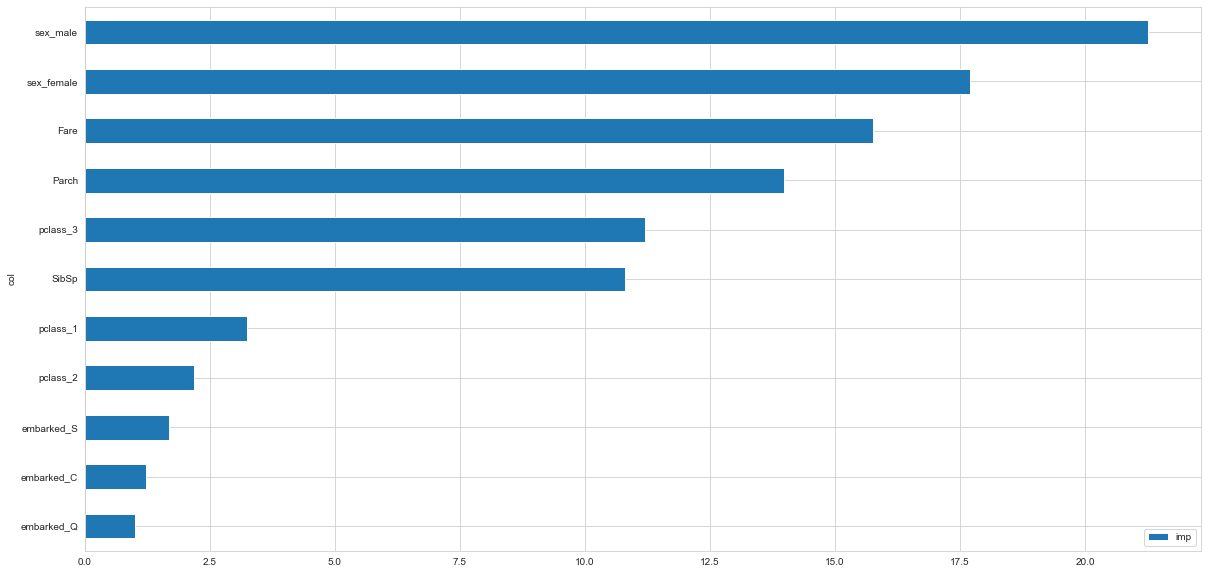

In [783]:
# Plot the feature importance scores
feature_importance(catboost_model, X_train)

#### Why would you want feature importance?

Featrue importance shows how much each feature contributed to the model.

You could take this information and remove features which don't contribute much to reduce dimenstionality (and save compute).

You could improve features which don't offer much to the overall model.

Or you could improve features which offer more to the model. In this case, there aren't many ways you could improve sex as it's already a binary.

Feature importance figures also show people who may not be familiar with the problem what features of their data are most important when it comes to making predictions with machine learning models.

## Precision and Recall

Precision and recall are two metrics which are used for cases where you have have an imbalanced classification problem.

For example, you may have 100,000 people and only 1 of them gets a certain disease. If your model predicts that all people don't have the disease, it only misses 1 in 100,000 so its accuracy is 99.999%. But this isn't really helpful.

This is where precision an recall come in.

**Recall** = a metric which measures a models ability to find all the relevant cases in a dataset.

Recall would be the models ability to find the 1 person in 100,000 who has the disease.

**Precision** = a metric which measures a models ability to correctly identify only relevant instances.

In our example, Precision would be if the model found the 1 person who had the disease, did they actually have the disease.

Combining the precision and recall, gives an **F1 score**.

These metrics will all fall between 0 and 1, with a higher value being better.

Although, they don't necessarily need to come into play for our Titantic problem, they're worth remembering for your future work.

In [788]:
metrics = ['Precision', 'Recall', 'F1', 'AUC']

eval_metrics = catboost_model.eval_metrics(train_pool,
                                           metrics=metrics,
                                           plot=True)

for metric in metrics:
    print(str(metric)+": {}".format(np.mean(eval_metrics[metric])))

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Precision: 0.8286662683284687
Recall: 0.6833382352941176
F1: 0.7489789466084935
AUC: 0.8842839467480982


Recall is low, this means there's a higher amount of false negatives (predicting Did not survive when it was actually Survived).

Precision is higher therefore there's less false positives (predicting Survived, when it was actually Did not survive).

**Challenge:** What are some ways to visualise precision and recall? Hint: You may want to look into what a confusion matrix is, you can find much more information in this blog post: Beyond Accuracy: Precision and Recall

## Submission
et's use the model with the highest cross-validation accuracy score to make a prediction on the test dataset and then submit our predictions to Kaggle.

We want to make predictions on the same kind of columnns our model is trained on.

So we have to select the subset of right columns of the `test` dateframe, encode them and make a prediciton with our model.

In [789]:
# We need our test dataframe to look like this one
X_train.head()

,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,0,71.2833,1,0,0,1,0,1,0,0
2,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,0,53.1000,0,0,1,1,0,1,0,0
4,0,0,8.0500,0,0,1,0,1,0,0,1


In [790]:
# Our test dataframe has some columns our model hasn't been trained on
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [791]:
# One hot encode the columns in the test data frame (like X_train)
test_embarked_one_hot = pd.get_dummies(test['Embarked'],
                                       prefix='embarked')

test_sex_one_hot = pd.get_dummies(test['Sex'],
                                  prefix='sex')

test_plcass_one_hot = pd.get_dummies(test['Pclass'],
                                     prefix='pclass')

In [792]:
# Combine the test one hot encoded columns with test
test = pd.concat([test,
                  test_embarked_one_hot,
                  test_sex_one_hot,
                  test_plcass_one_hot], axis=1)

In [794]:
# Let's look at test, it should have one hot encoded columns now
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,1,0,0,1,0,0,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0,0,1,1,0,0,0,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,1,0,0,1,0,1,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0,0,1,0,1,0,0,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0,0,1,1,0,0,0,1


The columns in `test` have been converted to the same format at df_con_enc. Now we can make predictions on the `test` dataframe columns we built a model on.

We can find the columns we made predictions on with `X_train.columns`.

In [796]:
# Create a list of columns to be used for the predictions
wanted_test_columns = X_train.columns
wanted_test_columns

Index(['SibSp', 'Parch', 'Fare', 'embarked_C', 'embarked_Q', 'embarked_S',
       'sex_female', 'sex_male', 'pclass_1', 'pclass_2', 'pclass_3'],
      dtype='object')

In [797]:
# Make a prediction using the CatBoost model on the wanted columns
predictions = catboost_model.predict(test[wanted_test_columns])

In [798]:
# Our predictions array is comprised of 0's and 1's (Survived or Did Not Survive)
predictions[:20]

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1])

In [799]:
# Create a submisison dataframe and append the relevant columns
submission = pd.DataFrame()
submission['PassengerId'] = test['PassengerId']
submission['Survived'] = predictions # our model predictions on the test dataset
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [800]:
# What does our submission have to look like?
gender_submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [802]:
# Are our test and submission dataframes the same length?
if len(submission) == len(test):
    print("Submission dataframe is the same length as test ({} rows).".format(len(submission)))
else:
    print("Dataframes mismatched, won't be able to submit to Kaggle.")

Submission dataframe is the same length as test (418 rows).


In [807]:
# Convert submission dataframe to csv for submission to csv for Kaggle submission
submission.to_csv('catboost_submission.csv', index=False)
print('Submission CSV is ready!')

Submission CSV is ready!


In [810]:
# Check the submission csv to make sure it's in the right format
submissions_check = pd.read_csv("catboost_submission.csv")
submissions_check.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
